## 패키지 가져오기

In [1]:
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


In [3]:
# 2023년 3월 1일 기준 KOSPI와 KOSDAQ의 종목 수를 파악
start_date, end_date = "2015-02-11", "2023-03-01"
kospi_tickers = stock.get_market_ticker_list(end_date, market='KOSPI')
kosdaq_tickers = stock.get_market_ticker_list(end_date, market='KOSDAQ')
all_tickers = kospi_tickers + kosdaq_tickers

print("KOSPI 종목 수: ", len(kospi_tickers))
print("KOSDAQ 종목 수: ", len(kosdaq_tickers))
print("전체 종목 수: ", len(all_tickers))

KOSPI 종목 수:  943
KOSDAQ 종목 수:  1615
전체 종목 수:  2558


## 전략 수립 및 구현

14일을 기준으로 RSI를 계산하고, RSI가 70이상이면 초과매수국면으로 판단하여 매수, RSI가 30이하이면 초과매도 국면으로 판단하여 매도하는 전략.  
이 때, 각 자산의 매수 및 매도 비중은 모두 동일 가중 방식을 사용하여 결정. 한편, 리밸런싱 주기는 5일로 설정.  
2015년 3월~2023년 2월에 KOSPI,KOSDAQ에 있는 모든 주식을 대상으로 전략을 실행.  
백테스트한 결과, 연간 약 -16.5% 정도의 수익률을 기록함.

In [4]:
# 1주(5 영업일)을 기준으로 rebalancing을 실시
rebalance_period = 5
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index[::rebalance_period]
rebalance_date = pd.to_datetime(rebalance_date, format='%Y-%m-%d')
rebalance_date[:rebalance_period]

DatetimeIndex(['2015-02-11', '2015-02-23', '2015-03-02', '2015-03-09',
               '2015-03-16'],
              dtype='datetime64[ns]', name='날짜', freq=None)

In [5]:
# 쓰이는 모든 티커들을 모음
all_tickers = []
for date in tqdm(rebalance_date):
    kospi_tickers = stock.get_market_ticker_list(date, market='KOSPI')
    kosdaq_tickers = stock.get_market_ticker_list(date, market='KOSDAQ')
    all_tickers += kospi_tickers
    all_tickers += kosdaq_tickers
all_tickers = list(set(all_tickers))
print(f"해당 기간동안의 모든 ticker 개수는 {len(all_tickers)}")

100%|██████████| 397/397 [03:50<00:00,  1.72it/s]

해당 기간동안의 모든 ticker 개수는 2863


In [6]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('RSI_price_df.csv')

100%|██████████| 2863/2863 [03:59<00:00, 11.96it/s]


In [7]:
price_df = pd.read_csv('RSI_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,023160,021080,080580,101530,125210,347140,008600,900110,003200,240810,...,321550,356860,013360,011320,001210,038060,307930,031510,105330,151860
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-11,10750,1600,7775,0.0,0.0,0.0,1310,1590,172000,0.0,...,0.0,0.0,647,4190,22906,6060,0.0,2305,5239,5030
2015-02-12,10650,1605,7550,0.0,0.0,0.0,1320,1532,172000,0.0,...,0.0,0.0,647,4180,23054,5930,0.0,2285,5100,5080
2015-02-13,10550,1645,7525,0.0,0.0,0.0,1310,1570,171000,0.0,...,0.0,0.0,644,4110,22906,6090,0.0,2300,5157,5230
2015-02-16,10650,1705,7325,0.0,0.0,0.0,1340,1532,171000,0.0,...,0.0,0.0,688,4105,21815,6080,0.0,2315,4928,5230
2015-02-17,10900,1710,7325,0.0,0.0,0.0,1345,1532,173000,0.0,...,0.0,0.0,721,4160,22261,6100,0.0,2315,4797,5280


In [8]:
# RSI 계산
# timeperiod=14를 사용
rsi = price_df.copy()
for col in price_df.columns:
    rsi[col] = RSI(price_df[col], timeperiod=14)
rsi = rsi.fillna(0)

In [9]:
# 롱숏 포트폴리오를 만들기로 함
# RSI 70이상이면 숏, 30이하면 롱 
# 결측 값들은 롱숏 하지 않음
# 비중은 롱과 숏 모두 동일가중방식을 사용
def calculate_weights(arr, long=30, short=70):
    long_signal = ((arr <= long) & (arr > 0)).astype(int)
    short_signal = (arr >= short).astype(int)
    long_cnt = np.sum(long_signal)
    short_cnt = np.sum(short_signal)
    if long_cnt > 0:
        long_signal = long_signal / long_cnt
    if short_cnt > 0:
        short_signal = -1 * short_signal / short_cnt
    return long_signal + short_signal
            
weights = rsi.apply(calculate_weights, axis=1)

In [10]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [11]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,023160,021080,080580,101530,125210,347140,008600,900110,003200,240810,...,321550,356860,013360,011320,001210,038060,307930,031510,105330,151860
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-22,0.052191,0.005272,0.002122,-0.007257,0.004431,0.0,-0.022956,-0.006061,-0.009580,-0.001592,...,0.002004,0.005669,-0.007692,0.014901,-0.024272,0.042502,0.016418,-0.023907,0.002030,0.064857
2023-02-23,-0.020821,-0.020979,0.020646,-0.005848,-0.009559,0.0,-0.020558,-0.006098,-0.006696,-0.017544,...,-0.010000,-0.006764,-0.029070,0.004894,-0.041791,-0.013077,0.017621,-0.019713,-0.008105,-0.012040
2023-02-24,0.018136,-0.016071,0.031639,-0.038235,0.028953,0.0,-0.008996,-0.018405,-0.004494,-0.019481,...,-0.029293,-0.017594,0.000000,-0.003247,-0.025961,-0.003118,0.040404,-0.006094,0.018386,0.020072
2023-02-27,-0.003071,0.007260,0.018100,0.001529,-0.009380,0.0,0.007564,0.006250,-0.010534,0.028146,...,0.003122,-0.008088,-0.003992,0.040717,0.022388,-0.004691,-0.005548,0.023299,0.021063,0.003514
2023-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,0.001813
2023-02-22,0.003016
2023-02-23,0.001545


In [13]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,0.000000
...,...
2023-02-21,-0.751198
2023-02-22,-0.750448
2023-02-23,-0.750062


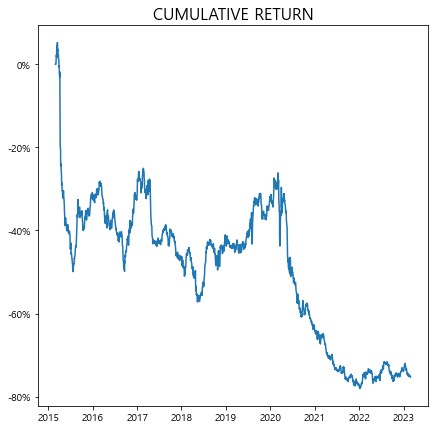

In [14]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## 자세한 결과 분석

In [15]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

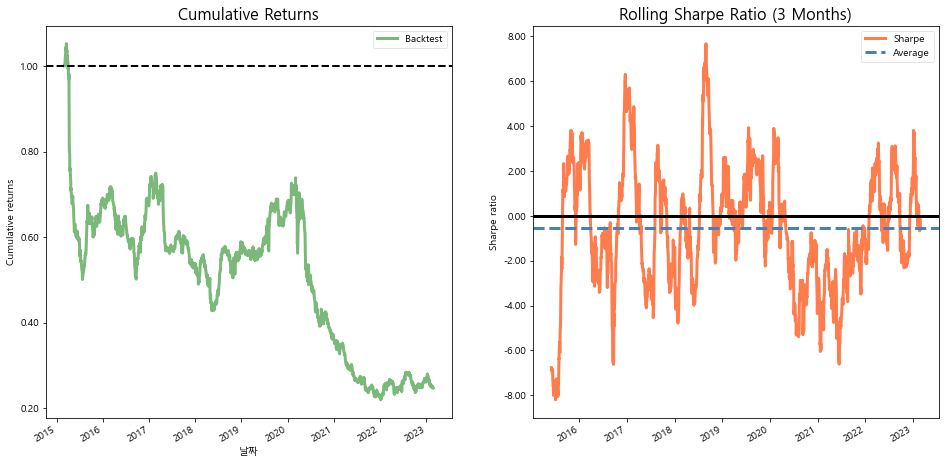

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2015-03-02
End date,2023-02-27
Total months,93
,Backtest
Annual return,-16.373%
Cumulative returns,-75.286%
Annual volatility,21.16%
Sharpe ratio,-0.74
Calmar ratio,-0.21
Stability,0.69
Max drawdown,-79.123%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,79.12,2015-03-18,2022-01-06,NaT,NaN
1,0.71,2015-03-13,2015-03-16,2015-03-17,3
2,0.18,2015-03-09,2015-03-10,2015-03-12,4
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


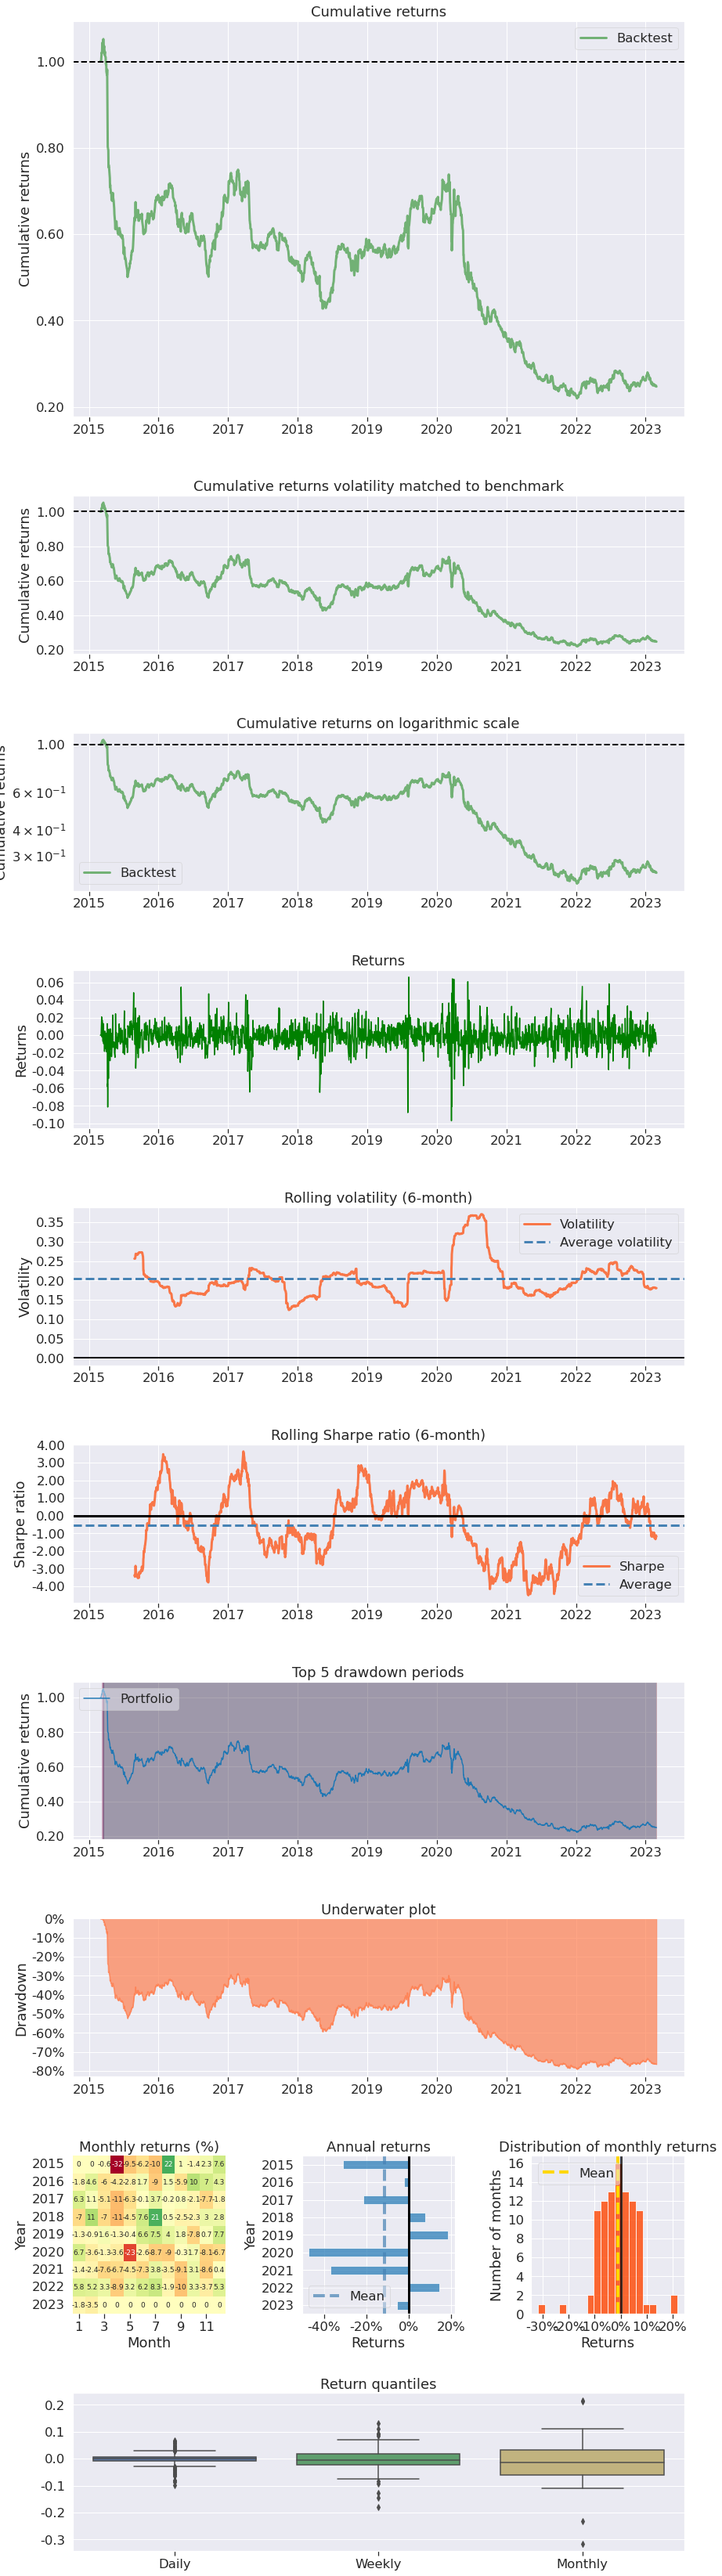

In [17]:
pf.create_returns_tear_sheet(daily_return['daily_return'])

## 전략수정(매일 리밸런싱 실시)

위의 RSI 기반 전략의 성과가 저조하여 리밸런싱 주기를 daily로 변경

### 전략 수정 시, 결과가 더 안 좋아짐

In [18]:
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index
rebalance_date = pd.to_datetime(rebalance_date, format='%Y-%m-%d')
rebalance_date

DatetimeIndex(['2015-02-11', '2015-02-12', '2015-02-13', '2015-02-16',
               '2015-02-17', '2015-02-23', '2015-02-24', '2015-02-25',
               '2015-02-26', '2015-02-27',
               ...
               '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-20',
               '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='날짜', length=1981, freq=None)

In [19]:
price_df = pd.read_csv('RSI_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

# RSI 계산
# timeperiod=14를 사용
rsi = price_df.copy()
for col in price_df.columns:
    rsi[col] = RSI(price_df[col], timeperiod=14)
rsi = rsi.fillna(0)


# 롱숏 포트폴리오를 만들기로 함
# RSI 70이상이면 숏, 30이하면 롱 
# 결측 값들은 롱숏 하지 않음
# 비중은 롱과 숏 모두 동일가중방식을 사용
def calculate_weights(arr, long=30, short=70):
    long_signal = ((arr <= long) & (arr > 0)).astype(int)
    short_signal = (arr >= short).astype(int)
    long_cnt = np.sum(long_signal)
    short_cnt = np.sum(short_signal)
    if long_cnt > 0:
        long_signal = long_signal / long_cnt
    if short_cnt > 0:
        short_signal = -1 * short_signal / short_cnt
    return long_signal + short_signal
            
weights = rsi.apply(calculate_weights, axis=1)

# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,023160,021080,080580,101530,125210,347140,008600,900110,003200,240810,...,321550,356860,013360,011320,001210,038060,307930,031510,105330,151860
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-22,0.052191,0.005272,0.002122,-0.007257,0.004431,0.0,-0.022956,-0.006061,-0.009580,-0.001592,...,0.002004,0.005669,-0.007692,0.014901,-0.024272,0.042502,0.016418,-0.023907,0.002030,0.064857
2023-02-23,-0.020821,-0.020979,0.020646,-0.005848,-0.009559,0.0,-0.020558,-0.006098,-0.006696,-0.017544,...,-0.010000,-0.006764,-0.029070,0.004894,-0.041791,-0.013077,0.017621,-0.019713,-0.008105,-0.012040
2023-02-24,0.018136,-0.016071,0.031639,-0.038235,0.028953,0.0,-0.008996,-0.018405,-0.004494,-0.019481,...,-0.029293,-0.017594,0.000000,-0.003247,-0.025961,-0.003118,0.040404,-0.006094,0.018386,0.020072
2023-02-27,-0.003071,0.007260,0.018100,0.001529,-0.009380,0.0,0.007564,0.006250,-0.010534,0.028146,...,0.003122,-0.008088,-0.003992,0.040717,0.022388,-0.004691,-0.005548,0.023299,0.021063,0.003514
2023-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,-0.007535
...,...
2023-02-21,0.001813
2023-02-22,0.005168
2023-02-23,0.000857


In [21]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2015-03-02,0.000000
2015-03-03,0.000000
2015-03-04,0.000000
2015-03-05,0.000000
2015-03-06,-0.007535
...,...
2023-02-21,-0.928015
2023-02-22,-0.927643
2023-02-23,-0.927581


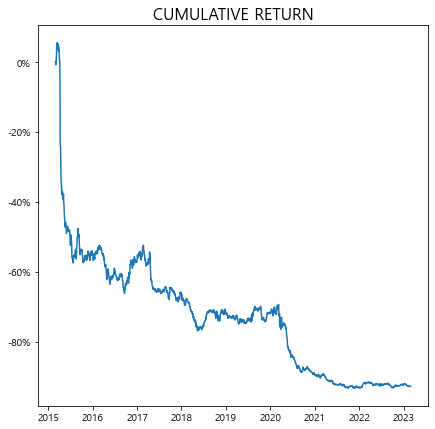

In [22]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

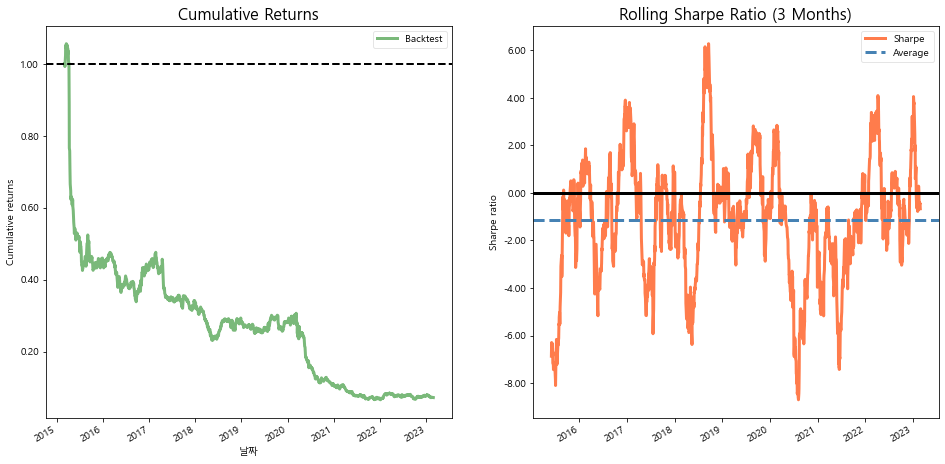

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)